# **Análisis Exploratorio (EDA) — Descomposición de la serie.**
Se marca el inicio del **análisis exploratorio de datos (EDA)**, un paso fundamental para comprender en profundidad el comportamiento de las series históricas que utilizaremos en la modelización.

En esta etapa, el objetivo principal es **investigar la dinámica temporal de las acciones** y de los índices de referencia, identificando patrones recurrentes, tendencias de largo plazo, ciclos económicos, periodos de crisis y episodios de alta volatilidad. Esta exploración inicial no solo permite entender cómo se han comportado los valores en distintos contextos macroeconómicos, sino también detectar posibles **anomalías o inconsistencias en los datos** (huecos, valores atípicos, errores de origen, etc.) que deban corregirse antes de continuar.

El segundo gran propósito de esta fase es **sentar las bases conceptuales y técnicas para las transformaciones posteriores**. A partir del EDA, se definirán los criterios para asegurar la **estacionariedad** de las series, se evaluará la influencia de variables **exógenas** (como tasas de interés, tipos de cambio o eventos macroeconómicos relevantes) y se determinará la **estructura temporal óptima** mediante el análisis de retardos o *lags*.


In [2]:
# Library imports
import os
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Set working directory to project root
os.chdir(Path.cwd().parent)

In [4]:
# Repository imports
from src.data.normalize_csv import normalize_and_save

In [5]:
# Environment configurations
RAW_DIR = Path(".cache/raw")
PROC_DIR = Path(".cache/processed")
FIG_DIR = Path("reports/figures")

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

SYMBOLS = ["BBVA.MC", "SAN.MC"]

In [6]:
# Matplotlib configurations
plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True

## **Ingesta y normalización de datos — Pipeline base**
Esta sección integra la fase de ingesta de datos y su limpieza estructural. Se normalizan los CSVs provenientes de fuentes externas (como Yahoo Finance) mediante el pipeline de normalización definido en el repositorio, asegurando una estructura de columnas estándar y tipos de datos consistentes.

Se valida la integridad de las columnas clave, se rellenan valores faltantes según las reglas del proyecto y se exporta el dataset limpio a una ubicación controlada dentro de la caché.
El resultado es una base uniforme y trazable lista para el análisis exploratorio.

In [7]:
bbva = pd.read_csv(RAW_DIR / "BBVA.MC.csv", parse_dates=["Date"])
san = pd.read_csv(RAW_DIR / "SAN.MC.csv", parse_dates=["Date"])

In [8]:
bbva.head()  # Similar for san.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,NaT,BBVA.MC,BBVA.MC,BBVA.MC,BBVA.MC,BBVA.MC,BBVA.MC,BBVA.MC,BBVA.MC
1,2000-01-03,13.69060230255127,13.757854461669922,13.594527244567871,13.6233491897583,4.040036201477051,8244257,0.0,0.0
2,2000-01-04,13.45041561126709,13.536882400512695,13.219837188720703,13.267873764038086,3.9346163272857666,8522096,0.0,0.0
3,2000-01-05,13.142976760864258,13.210229873657227,12.912399291992188,12.970044136047363,3.8462975025177,12159826,0.0,0.0
4,2000-01-06,12.970044136047363,12.970044136047363,12.970044136047363,12.970044136047363,3.8462975025177,0,0.0,0.0


In [9]:
bbva = normalize_and_save(".cache/raw/BBVA.MC.csv", symbol=SYMBOLS[0])
san = normalize_and_save(".cache/raw/SAN.MC.csv", symbol=SYMBOLS[1])

In [10]:
bbva.head()  # Similar for san.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2000-01-03,13.690602,13.757854,13.594527,13.623349,4.040036,8244257,0.0,0.0
1,2000-01-04,13.450416,13.536882,13.219837,13.267874,3.934616,8522096,0.0,0.0
2,2000-01-05,13.142977,13.210230,12.912399,12.970044,3.846298,12159826,0.0,0.0
3,2000-01-06,12.970044,12.970044,12.970044,12.970044,3.846298,0,0.0,0.0
4,2000-01-07,13.248659,13.248659,12.998866,13.133370,3.894731,62261944,0.0,0.0


In [11]:
for df in [bbva, san]:
    df.set_index("Date", inplace=True)

In [12]:
bbva.info()  # Similar for san.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6635 entries, 2000-01-03 to 2025-10-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6635 non-null   float64
 1   High          6635 non-null   float64
 2   Low           6635 non-null   float64
 3   Close         6635 non-null   float64
 4   Adj Close     6635 non-null   float64
 5   Volume        6635 non-null   int64  
 6   Dividends     6635 non-null   float64
 7   Stock Splits  6635 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 466.5 KB


In [13]:
bbva.describe()  # Similar for san.describe()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
count,6635.000000,6635.000000,6635.000000,6635.000000,6635.000000,6.635000e+03,6635.000000,6635.0
mean,9.290945,9.400302,9.172576,9.292671,4.636042,3.738564e+07,0.001537,0.0
std,3.835547,3.861604,3.808980,3.838877,2.104808,3.863822e+07,0.015459,0.0
min,2.150000,2.226000,2.128000,2.160000,1.616620,0.000000e+00,0.000000,0.0
25%,6.256721,6.342500,6.134500,6.254222,3.454504,1.603442e+07,0.000000,0.0
50%,8.685125,8.829000,8.579443,8.685125,4.171334,2.670634e+07,0.000000,0.0
75%,12.119785,12.247084,12.014103,12.105374,5.005046,4.477341e+07,0.000000,0.0
max,19.291739,19.483889,19.166842,19.291739,17.259270,6.009019e+08,0.410000,0.0


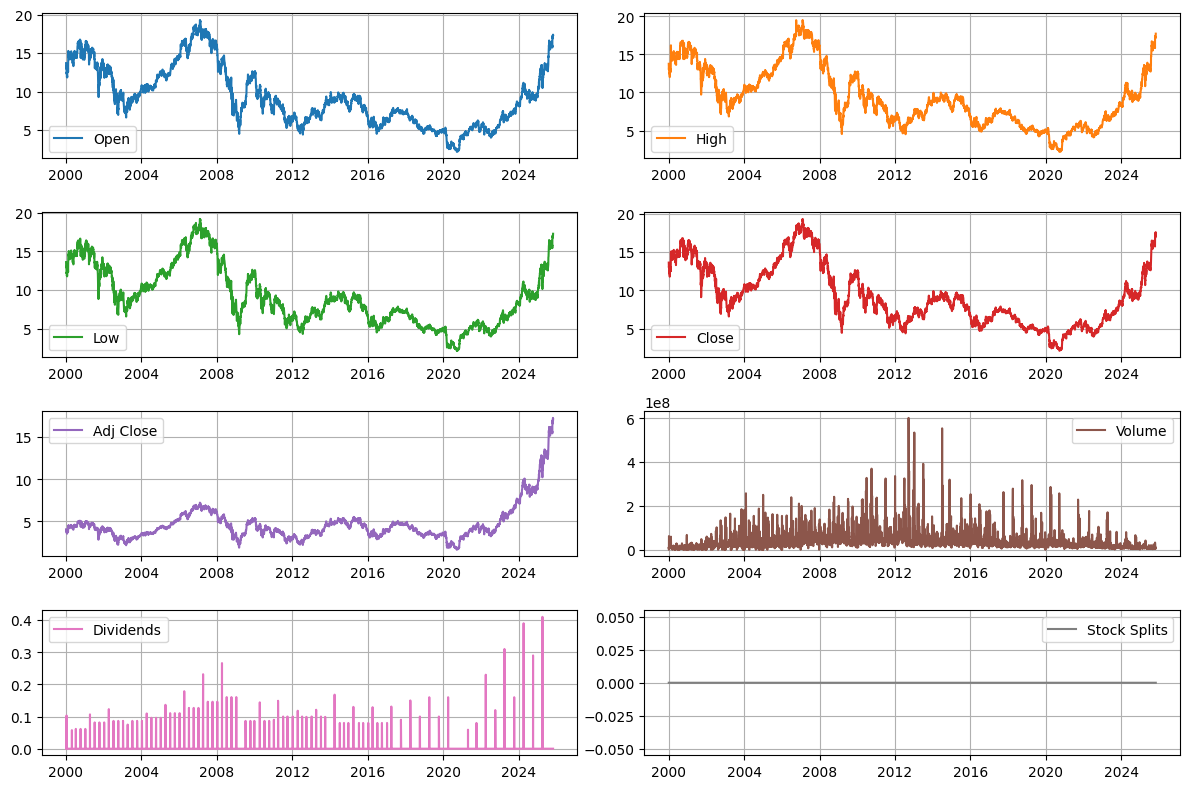

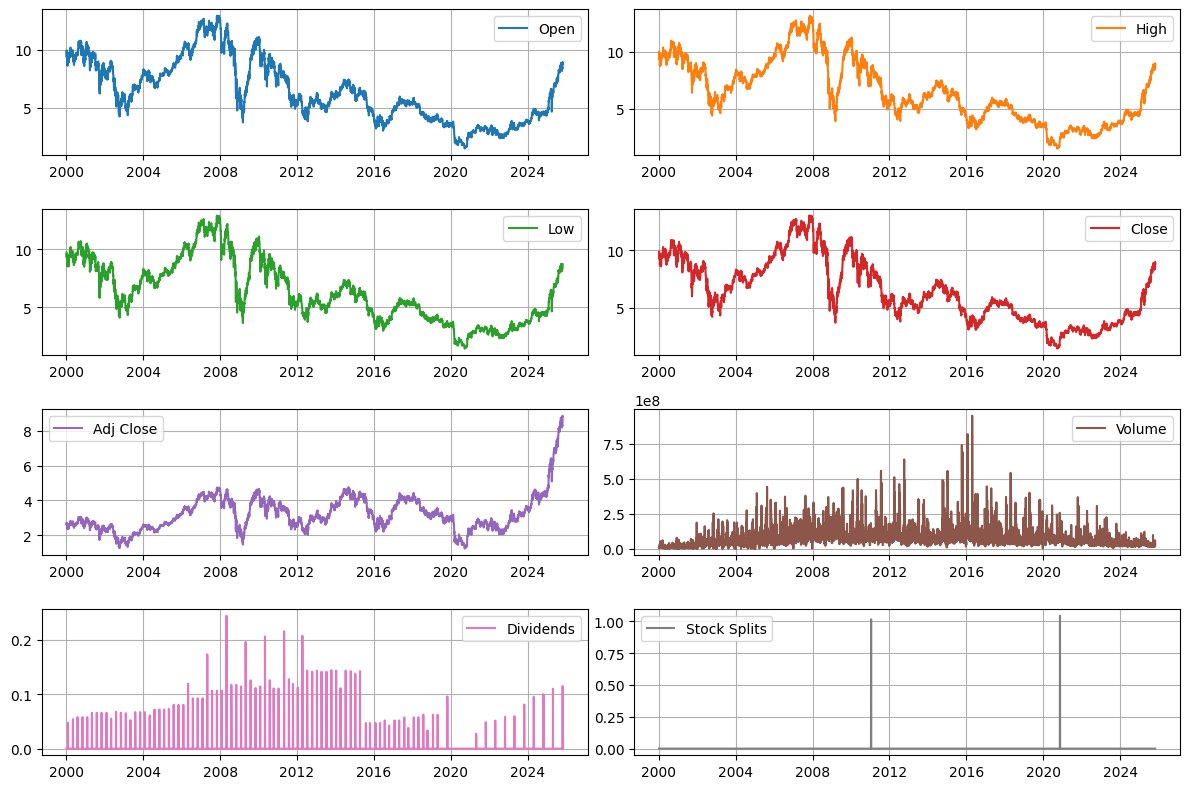

In [14]:
for i in bbva, san:
    i.plot(
        kind="line",
        subplots=True,
        title=None,
        xlabel="",
        layout=(4, 2),
        sharex=False,
        sharey=False,
        figsize=(12, 8),
    )
    plt.tight_layout()
    plt.show()

In [15]:
for df in bbva, san:
    df.drop(columns=["Stock Splits"], inplace=True)  # No splits in data, or low impact

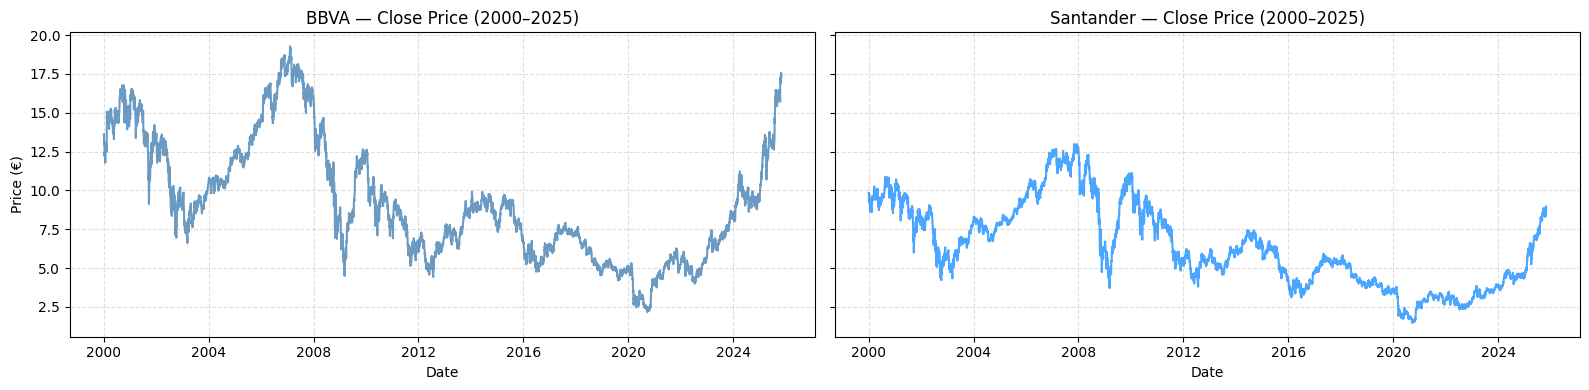

In [16]:
fig, axes = plt.subplots(1, 2, sharey=True)

# Subplot: BBVA
axes[0].plot(bbva.index, bbva["Close"], color="steelblue", alpha=0.8)
axes[0].set_title("BBVA — Close Price (2000–2025)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (€)")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Subplot: Santander
axes[1].plot(san.index, san["Close"], color="dodgerblue", alpha=0.8)
axes[1].set_title("Santander — Close Price (2000–2025)")
axes[1].set_xlabel("Date")
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## **Validación de la serie temporal y consistencia de fechas**
Antes de cualquier análisis, se verifica la continuidad y coherencia temporal de las series.
Se comprueba que no existan duplicados, fechas desordenadas o huecos no explicables por festivos bursátiles.

Este control garantiza la fiabilidad del análisis posterior y evita sesgos provocados por errores de muestreo o discontinuidades en la serie de precios.

In [17]:
dupes_bbva = bbva.index.duplicated().sum()
dupes_san = san.index.duplicated().sum()

print(f"Duplicados BBVA: {dupes_bbva} | Duplicados SAN: {dupes_san}")

Duplicados BBVA: 0 | Duplicados SAN: 0


In [18]:
diff_bbva = bbva.index.to_series().diff().dt.days.to_frame(name="GAP_DAYS")
diff_san = san.index.to_series().diff().dt.days.to_frame(name="GAP_DAYS")

pd.DataFrame(
    {
        "BBVA_diff_days": diff_bbva["GAP_DAYS"].describe(),
        "SAN_diff_days": diff_san["GAP_DAYS"].describe(),
    }
).T

,count,mean,std,min,25%,50%,75%,max
BBVA_diff_days,6634.0,1.421917,0.8407,1.0,1.0,1.0,1.0,6.0
SAN_diff_days,6634.0,1.421917,0.8407,1.0,1.0,1.0,1.0,6.0


Las series temporales de BBVA y SAN presentan un espaciado temporal regular, con un promedio de 1.42 días entre observaciones. No se detectan duplicados ni huecos anómalos fuera de los esperables por fines de semana o festivos bursátiles. El salto máximo de 6 días corresponde a periodos de cierre de mercado (e.g., vacaciones de Navidad). Por tanto, las series son temporalmente consistentes y aptas para análisis secuencial (EDA y RNN).

> El patrón es idéntico para BBVA y SAN, lo cual indica que ambos siguen el calendario de negociación de la Bolsa Española (BME).

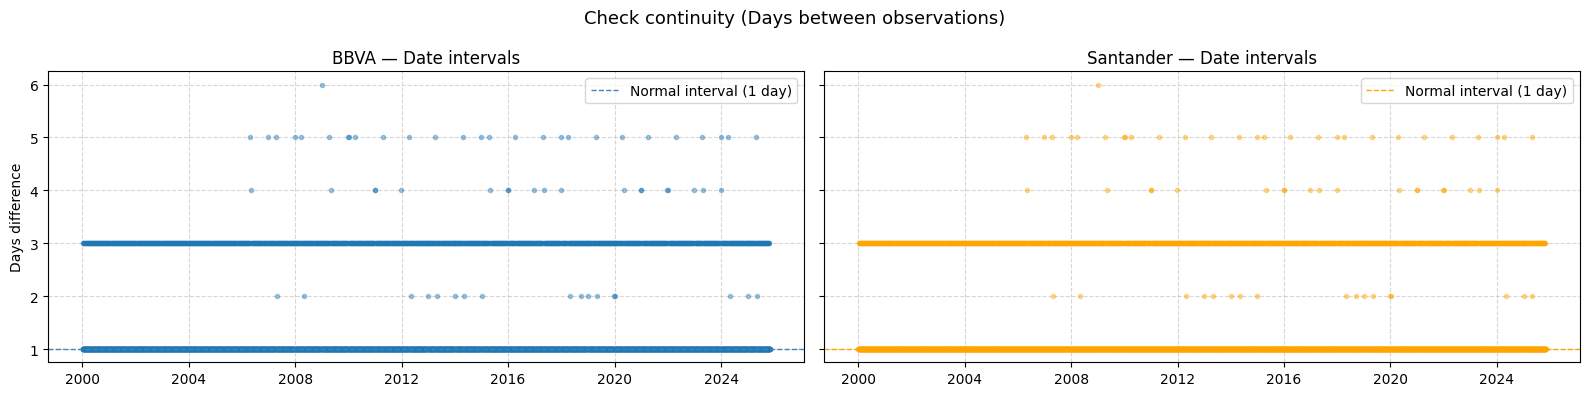

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes = axes.ravel()

# Subplot: BBVA
axes[0].plot(bbva.index, diff_bbva, marker=".", linestyle="none", alpha=0.4)
axes[0].axhline(1, color="steelblue", lw=1, ls="--", label="Normal interval (1 day)")
axes[0].set_title("BBVA — Date intervals")
axes[0].set_ylabel("Days difference")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Subplot: SAN
axes[1].plot(
    san.index, diff_san, marker=".", linestyle="none", alpha=0.4, color="orange"
)
axes[1].axhline(1, color="orange", lw=1, ls="--", label="Normal interval (1 day)")
axes[1].set_title("Santander — Date intervals")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Check continuity (Days between observations)", fontsize=13)
plt.show()

Durante el análisis exploratorio se detectó que entre algunos registros consecutivos de la serie temporal existen diferencias de más de un día natural. Esto se debe a los fines de semana y festivos bursátiles, en los que el mercado permanece cerrado. Aunque los datos se registren de forma diaria, el índice temporal no es estrictamente regular, ya que entre el viernes y el lunes pueden transcurrir varios días sin cotización.

En los **modelos RNN, LSTM y GRU, que aprenden patrones secuenciales en función del orden temporal,** esta discontinuidad puede afectar al aprendizaje: **El modelo asume que entre dos observaciones consecutivas siempre transcurre el mismo intervalo**, lo cual no es cierto en los días posteriores a cierres de mercado.

> Diversos estudios, como *Keim & Stambaugh (1984), Müller et al. (2019) o Tsay (2010)*, confirman la existencia del denominado **“Weekend Effect”** y recomiendan incorporar variables de calendario o cierres prolongados como factores explicativos adicionales.

In [20]:
for df in diff_bbva, diff_san:
    df["GAP_FLAG"] = (df["GAP_DAYS"] > 3).astype(int)  # Flag for long gaps
    # Extract year and month from index
    df["YEAR"] = df.index.year
    df["MONTH"] = df.index.month

In [21]:
gaps_bbva = (
    diff_bbva.loc[diff_bbva["GAP_FLAG"] == 1]
    .groupby(["YEAR", "MONTH"])
    .size()
    .unstack(fill_value=0)
)

gaps_san = (
    diff_san.loc[diff_san["GAP_FLAG"] == 1]
    .groupby(["YEAR", "MONTH"])
    .size()
    .unstack(fill_value=0)
)

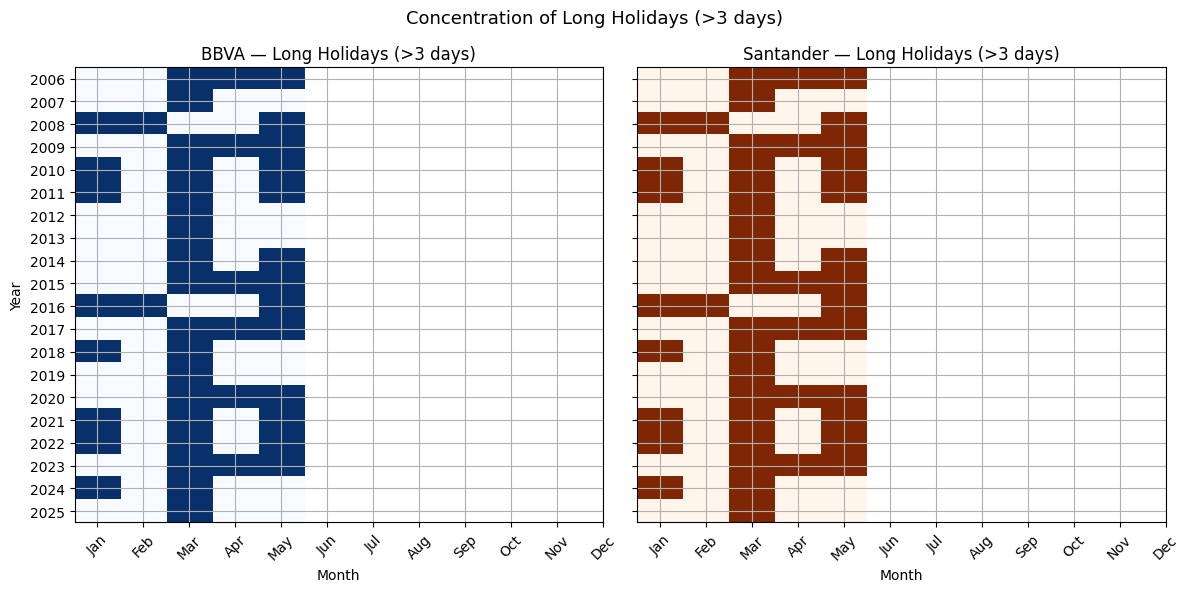

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.ravel()

axes[0].imshow(gaps_bbva.values, aspect="auto", cmap="Blues")
axes[0].set_title("BBVA — Long Holidays (>3 days)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=45,
)
axes[0].set_yticks(range(len(gaps_bbva.index)))
axes[0].set_yticklabels(gaps_bbva.index)

axes[1].imshow(gaps_san.values, aspect="auto", cmap="Oranges")
axes[1].set_title("Santander — Long Holidays (>3 days)")
axes[1].set_xlabel("Month")
axes[1].set_xticks(range(12))
axes[1].set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=45,
)
axes[1].set_yticks(range(len(gaps_san.index)))
axes[1].set_yticklabels(gaps_san.index)

plt.suptitle("Concentration of Long Holidays (>3 days)", fontsize=13)
plt.tight_layout()
plt.show()

Aunque se podría representar la diferencia entre fechas como el número exacto de días transcurridos, se optó por una variable binaria. Esto se debe a que los efectos de los fines de semana y festivos no son proporcionales a su duración, sino cualitativos (cambio de régimen temporal). En modelos RNN, una codificación binaria evita suposiciones lineales erróneas, mejora la estabilidad y permite al modelo distinguir de forma simple los días de reapertura del mercado.

In [23]:
for df in (
    bbva,
    san,
):  # Add 'Is Gap' column to original dataframes: 1 if gap, 0 otherwise
    diff_days = df.index.to_series().diff().dt.days.fillna(1)
    df["Is Gap"] = (diff_days > 1).astype(int)

## **Descomposición STL: tendencia, estacionalidad y residuo**
Se aplica la descomposición temporal mediante el método STL (Seasonal-Trend Decomposition using Loess) para separar cada serie en sus componentes principales: tendencia a largo plazo, patrones estacionales recurrentes y ruido aleatorio.

Este análisis permite visualizar la estructura subyacente de la serie, identificar ciclos económicos o de mercado y distinguir entre fluctuaciones sistemáticas y movimientos puramente aleatorios.

In [24]:
decomp_bbva = seasonal_decompose(bbva["Close"], model="additive", period=252)
decomp_san = seasonal_decompose(san["Close"], model="additive", period=252)

In [25]:
def stat_decomp_plot(decomp, symbol):
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

    axes[0].plot(decomp.observed, color="blue")  # Observed: Original series
    axes[0].set_title("Observed")

    axes[1].plot(decomp.trend, color="orange")  # Trend: Long-term direction
    axes[1].set_title("Trend")

    axes[2].plot(decomp.seasonal, color="green")  # Seasonal: Repeating patterns
    axes[2].set_title("Seasonal")

    axes[3].plot(decomp.resid, color="purple")  # Residual: Random noise
    axes[3].set_title("Residual")

    years = pd.date_range(start="2000-01-01", end="2025-01-01", freq="YS")
    for ax in axes:
        ax.set_xticks(years)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-12-31"))

    fig.suptitle(
        f"{symbol} — Seasonal Decomposition", fontsize=16, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()

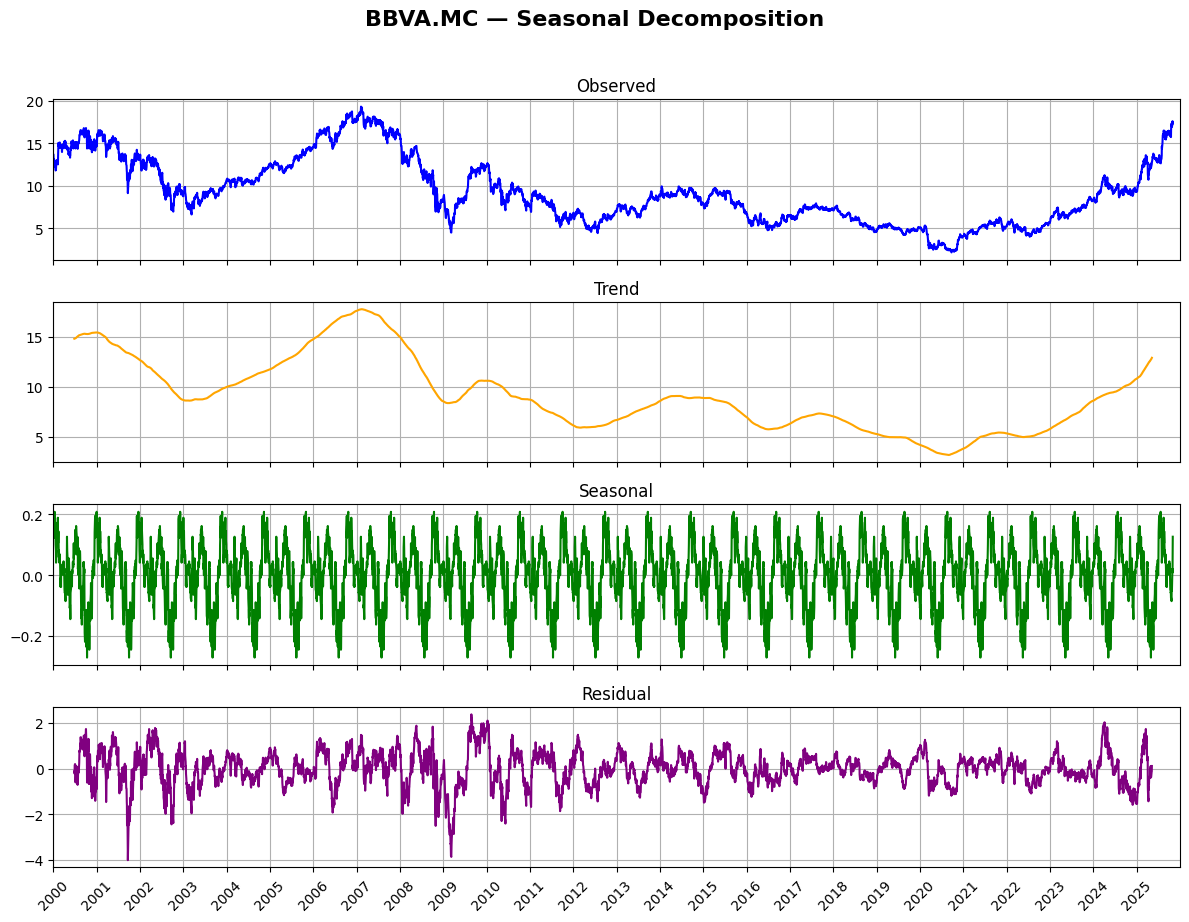

In [26]:
stat_decomp_plot(decomp_bbva, SYMBOLS[0])

La descomposición de la serie **BBVA.MC** permite aislar tres componentes clave:
tendencia (Trend), estacionalidad (Seasonal) y residuo (Residual). La observación conjunta evidencia que el comportamiento de BBVA refleja fielmente la evolución del sistema financiero español y global durante el periodo 2000-2025.

* **Tendencia (Trend):** La tendencia refleja claramente los ciclos económicos del sistema financiero español y global. Los tramos bajistas coinciden con crisis financieras; los alcistas, con fases de expansión o subida de tipos. Por tanto, el modelo RNN deberá incorporar variables exógenas macroeconómicas (por ejemplo, PIB, tipos BCE, IBEX-35, inflación o EUR/USD) para capturar esas dinámicas.

| Periodo       | Acontecimiento / noticia clave                                    | Efecto en la tendencia                                 |
| ------------- | ----------------------------------------------------------------- | ------------------------------------------------------ |
| **2000–2003** | Estallido de la burbuja “.com” y menor crédito global             | **Caída inicial**; la banca reduce beneficios.         |
| **2003–2007** | Expansión económica y burbuja inmobiliaria en España              | **Subida fuerte**; beneficios récord, crédito fácil.   |
| **2008–2009** | *Crisis financiera global* (Lehman Brothers, rescates)            | **Desplome**; BBVA pierde valor casi a la mitad.       |
| **2010–2012** | *Crisis de deuda soberana europea*; prima de riesgo 600 pb        | **Nueva caída** a mínimos (~6 €).                      |
| **2013–2015** | Reestructuración bancaria, BCE con tipos al 0 %                   | **Recuperación moderada**.                             |
| **2016**      | Brexit y entorno de tipos negativos                               | **Nuevo descenso** (márgenes presionados).             |
| **2018–2020** | Crecimiento débil y *COVID-19* (mar-2020)                         | **Caída a mínimos históricos** (~4 €).                 |
| **2021–2023** | *Subidas de tipos del BCE* (+4,5 pb desde jul-22) y fin del COVID | **Fuerte recuperación** de márgenes; subida sostenida. |
| **2024–2025** | Inflación controlada, beneficios récord y recompras               | **Consolidación alcista** hacia ~13 €.                 |

* **Estacional (Seasonal):** Ondas pequeñas y constantes a lo largo del tiempo (amplitud ±0.2). No existe una estacionalidad anual relevante; las variaciones no siguen un patrón regular de calendario. Por tanto, podemos prescindir de features de calendario complejas (como senos/cosenos de mes o día del año). En todo caso, se podrían probar variables trimestrales (Q1–Q4) porque los bancos publican resultados y dividendos cada trimestre. Esto confirmaría que los cambios de precio se deben a factores macro y no al calendario.

* **Ruido y volatilidad (Residual):** El residuo se expande en crisis (2001–2002, 2008–2009) y se contrae en periodos de calma prolongada. Los picos ±2 de 2009–2010 y 2024–2025 son “latigazos” típicos de noticias/resultados; los –4 marcan capitulaciones reales. Tras 2013 el mercado vive “ruido ordenado”, salvo sustos puntuales (COVID 2020, 2024–25 resultados/geopolítica). Acciones: Winsorizar retornos (p. ej., clip a percentil 0.5%/99.5%) para que picos tipo –4 o +2 no dominen el training; Crear EventFlags para: 2001–2002, 2008–2009, 2010 swings, COVID 2020, y spikes 2024–2025.

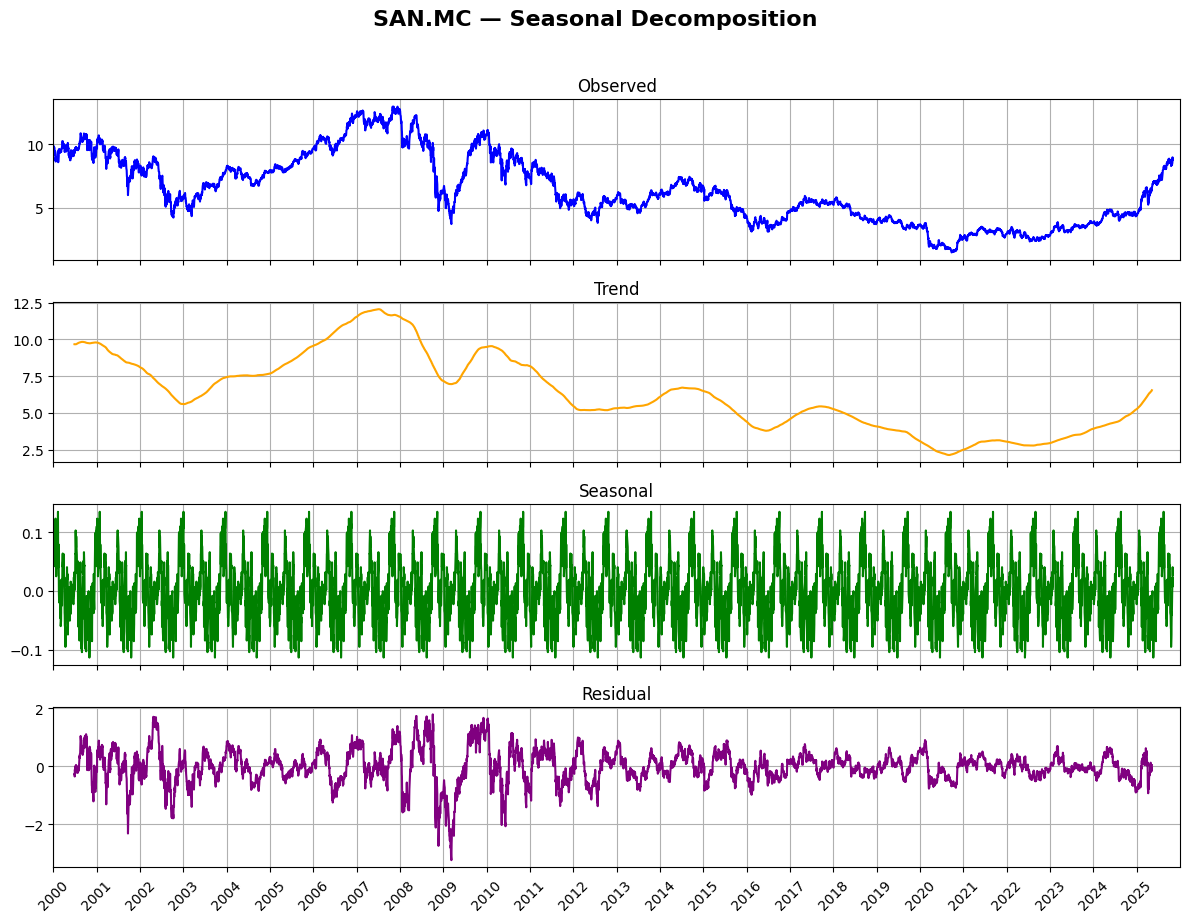

In [27]:
stat_decomp_plot(decomp_san, SYMBOLS[1])

**Ambas series — BBVA y Santander — muestran una estructura temporal casi idéntica**, con fases de expansión y contracción que coinciden con los grandes ciclos económicos y financieros de España y de la eurozona.
| Periodo       | Contexto macroeconómico principal                                             | Comportamiento observado en ambas tendencias                                       |
| ------------- | ----------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **2000–2003** | Estallido de la burbuja “.com” y desaceleración global                        | Caída inicial pronunciada (pérdida de confianza, caída de crédito).                |
| **2003–2007** | Bonanza previa a la crisis: auge inmobiliario, crédito abundante              | Fuerte tendencia alcista: beneficios récord, máximos históricos.                   |
| **2008–2009** | Gran Crisis Financiera global (Lehman Brothers, rescates)                     | Desplome simultáneo en ambos valores (–40 % aprox.), mínimos históricos.           |
| **2010–2012** | Crisis de deuda soberana en la eurozona, rescate bancario español             | Segunda fase bajista; pérdida de valor hasta ~6 €/4 €.                             |
| **2013–2019** | Política monetaria ultraexpansiva del BCE, tipos en 0 %                       | Larga lateralidad, precios estabilizados pero sin tendencia clara.                 |
| **2020**      | Crisis del COVID-19 (confinamientos, desplome global)                         | Nueva caída vertical; máximo pánico de mercado.                                    |
| **2021–2025** | Recuperación económica, subidas de tipos del BCE (+450 pb), beneficios récord | Tendencia claramente alcista y sincronizada; ambos valores duplican su cotización. |

Los dos bancos se comportan como **activos sistémicos, fuertemente dependientes del entorno macro**.
No hay divergencias significativas en la dirección ni en la magnitud de las oscilaciones: los factores que mueven uno mueven al otro.
* **Tendencia (Trend):** En ambos casos, las curvas de tendencia reflejan largos ciclos de crecimiento y crisis. Se identifican rupturas de régimen claras. La tendencia está **dominada por factores macroestructurales (PIB, tipos BCE, inflación, crédito).** El modelo RNN necesitará exógenas macroeconómicas para capturar esos ciclos.
* **Estacionalidad (Seasonal):** Componente **muy débil y repetitiva** en ambos activos. No hay variaciones regulares por mes o trimestre; los bancos **no muestran patrones cíclicos anuales fuertes.** La cotización **no depende del calendario sino de eventos macro y política monetaria.** En el modelo, bastará con variables simples de calendario (trimestre, fin de año) o incluso omitirlas.

* **Residual (Ruido / Volatilidad):** Los picos negativos de ambos coinciden con las crisis globales y europeas. Entre 2013 y 2019 el residuo se estabiliza dentro de ±1, reflejando un entorno de volatilidad baja. En 2024–2025 vuelven pequeños picos (+2/–1.5) ligados a publicaciones de resultados y ajustes geopolíticos.

## **Análisis de patrones semanales y mensuales**
En esta parte se estudia la estacionalidad desde una perspectiva temporal más granular.
Se analizan patrones por día de la semana y por mes para determinar si existen comportamientos repetitivos asociados a periodos concretos del calendario financiero.

> Aunque en la descomposición se mostró que la estacionalidad anual era débil, aún puede haber patrones más cortos. Descubrir si hay micro-ritmos repetitivos.

In [28]:
for df in [bbva, san]:
    df["Weekday"] = df.index.weekday
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["Quarter"] = df.index.quarter

# Simple percentage return calculation for analyzing relative performance without changing the base series
for df in [bbva, san]:
    df["ReturnPCT"] = df["Close"].pct_change() * 100

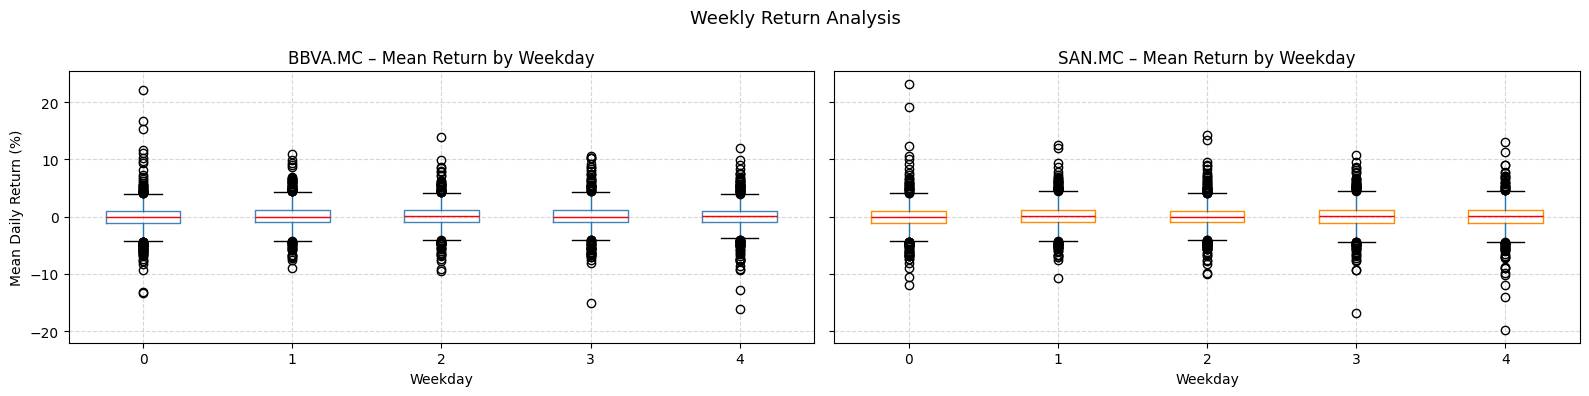

In [29]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes = axes.ravel()

# Subplot: BBVA
bbva.boxplot(
    column="ReturnPCT",
    by="Weekday",
    ax=axes[0],
    boxprops=dict(color="steelblue"),
    medianprops=dict(color="red"),
)
axes[0].set_title("BBVA.MC – Mean Return by Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Mean Daily Return (%)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Subplot: SAN
san.boxplot(
    column="ReturnPCT",
    by="Weekday",
    ax=axes[1],
    boxprops=dict(color="darkorange"),
    medianprops=dict(color="red"),
)
axes[1].set_title("SAN.MC – Mean Return by Weekday")
axes[1].set_xlabel("Weekday")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Weekly Return Analysis", fontsize=13)
plt.tight_layout()
plt.show()

Los boxplots semanales muestran **distribuciones simétricas y de amplitud similar** en los cinco días hábiles, con medianas cercanas a cero. **No se aprecia un efecto día de la semana.** Los puntos atípicos (outliers) corresponden a sesiones con noticias o crisis puntuales, sin repetirse en un día concreto, lo que sugiere que no existe estacionalidad intradía estructural. En consecuencia, no se incluirán variables de calendario semanal en el modelo RNN, manteniendo la entrada temporal continua sin fragmentación artificial.

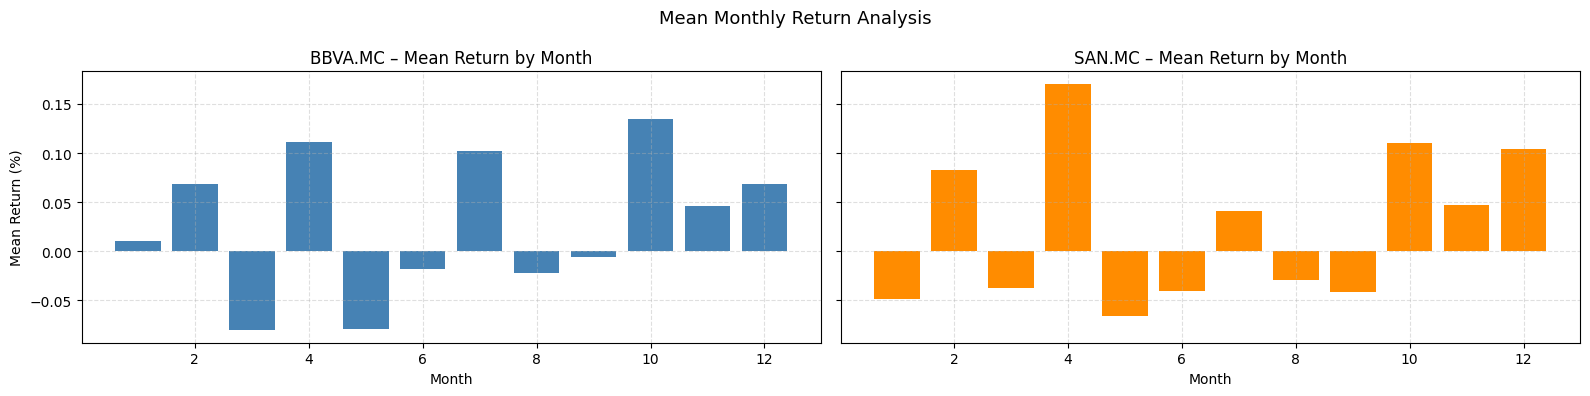

In [30]:
mean_month_bbva = bbva.groupby("Month")["ReturnPCT"].mean()
mean_month_san = san.groupby("Month")["ReturnPCT"].mean()

fig, axes = plt.subplots(1, 2, sharey=True)
axes = axes.ravel()

axes[0].bar(mean_month_bbva.index, mean_month_bbva.values, color="steelblue")
axes[0].set_title("BBVA.MC – Mean Return by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Mean Return (%)")
axes[0].grid(True, linestyle="--", alpha=0.4)

axes[1].bar(mean_month_san.index, mean_month_san.values, color="darkorange")
axes[1].set_title("SAN.MC – Mean Return by Month")
axes[1].set_xlabel("Month")
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.suptitle("Mean Monthly Return Analysis", fontsize=13)
plt.tight_layout()
plt.show()

El análisis mensual muestra que los **retornos medios se mantienen próximos a cero, sin un patrón estacional fuerte.** Se observan ligeras ganancias en febrero, abril, julio, octubre y diciembre, asociadas probablemente a la publicación de resultados y al efecto de cierre de ejercicio (“rally de fin de año”), y descensos moderados en mayo y junio, coincidentes con la toma de beneficios y el reparto de dividendos. Estos efectos son pequeños (±0.1 %–0.16 %) y **no justifican un modelado estacional explícito**, aunque pueden considerarse como contexto explicativo en la interpretación económica de los resultados. En resumen, **no se incluirán variables mensuales explícitas en el modelo RNN.**

## **Dinámica de volatilidad y detección de regímenes**
Aquí se evalúa la evolución de la volatilidad a lo largo del tiempo. Es decir, **cuánto varía el precio día a día**; cuando aumenta, indica que el mercado está nervioso o incierto. En series financieras, los periodos de alta volatilidad suelen coincidir con crisis, anuncios de tipos de interés o shocks macro. Se calculan medidas de dispersión móvil sobre los rendimientos para identificar fases de estabilidad e inestabilidad en los precios.

El análisis permite detectar periodos de crisis, burbujas o eventos macroeconómicos relevantes, aportando información crítica sobre los cambios de régimen y la sensibilidad del mercado.

In [31]:
for df in [
    bbva,
    san,
]:  # Calculate 30-day rolling volatility (standard deviation of returns)
    df["Vol30"] = df["ReturnPCT"].rolling(window=30).std()

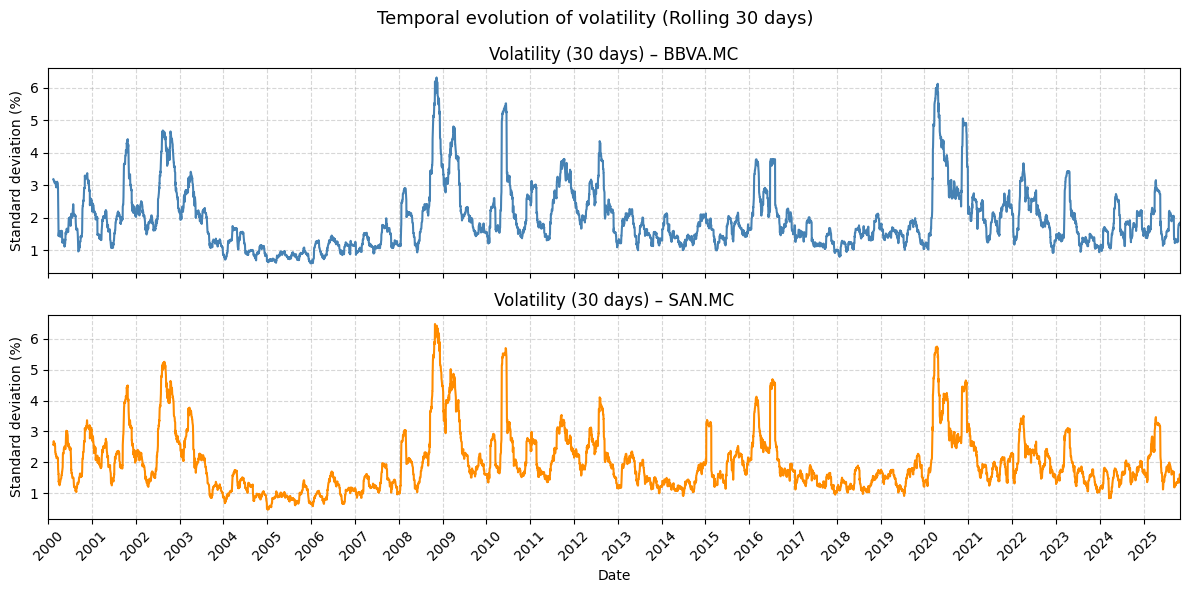

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(bbva.index, bbva["Vol30"], color="steelblue", label="BBVA.MC")
axes[0].set_title("Volatility (30 days) – BBVA.MC")
axes[0].set_ylabel("Standard deviation (%)")
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].plot(san.index, san["Vol30"], color="darkorange", label="SAN.MC")
axes[1].set_title("Volatility (30 days) – SAN.MC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Standard deviation (%)")
axes[1].grid(True, linestyle="--", alpha=0.5)

years = pd.date_range(start="2000-01-01", end="2025-01-01", freq="YS")

for ax in axes:
    ax.set_xticks(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-11-01"))

plt.suptitle("Temporal evolution of volatility (Rolling 30 days)", fontsize=13)
plt.tight_layout()
plt.show()

**Ambas curvas de volatilidad (rolling 30 días) son muy parecidas,** lo que confirma que ambos bancos:
* Responden al mismo contexto macroeconómico.
* Tienen ciclos de estrés financiero sincronizados.
* Presentan magnitudes de volatilidad muy similares (picos entre 6 % – 6.5 %).

| Periodo       | Interpretación económica                                                                                                            |
| ------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **2001–2002** | **Post-burbuja “dot-com”**: incertidumbre global, caída del crédito, inicio de ciclo bajista. Volatilidad elevada por desconfianza. |
| **2003–2006** | **Expansión económica**: crecimiento estable, confianza alta, baja volatilidad.                                                     |
| **2007–2009** | **Gran Crisis Financiera (GFC)**: pánico bancario global, máxima volatilidad (~6 %). Caída simultánea de ambos valores.             |
| **2010–2012** | **Crisis de deuda europea**: rescate bancario, dudas sobre España. Alta volatilidad (~5–6 %).                                       |
| **2013–2015** | **Recuperación con altibajos**; estabilidad monetaria BCE, leve tensión por Grecia (2015).                                          |
| **2016–2019** | **Tipos cero del BCE**; entorno de baja volatilidad salvo episodios puntuales (Brexit).                                             |
| **2020**      | **COVID-19**: volatilidad histórica, confinamientos y recuperación posterior.                                                       |
| **2021–2022** | **Inicio del ciclo de tipos del BCE** y guerra de Ucrania: repunte moderado.                                                        |
| **2023–2025** | **Normalización del mercado**, ligeros repuntes por resultados o ajustes geopolíticos.                                              |


In [33]:
for df in [bbva, san]:
    vol_z = (df["Vol30"] - df["Vol30"].mean()) / df[
        "Vol30"
    ].std()  # Z-score normalization of volatility
    df["RegimeFlag"] = np.where(vol_z > 1.5, 1, 0)

La variable `RegimeFlag` clasifica cada observación según el nivel relativo de volatilidad en el mercado. A partir de la volatilidad móvil de 30 días (`Vol30`), se calcula su desviación respecto a la media histórica (Z-Score). Cuando este valor **supera un umbral, se considera que la acción entra en un régimen de alta volatilidad**, asociado a periodos de crisis o inestabilidad. En caso contrario, se mantiene en un régimen normal o de baja volatilidad.

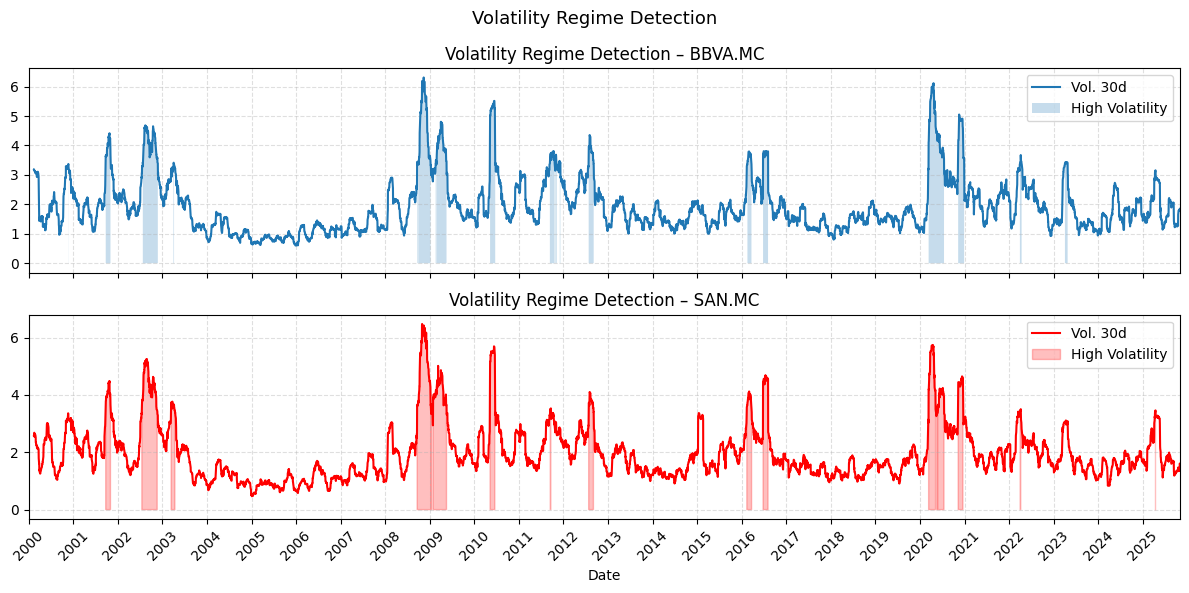

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(bbva.index, bbva["Vol30"], label="Vol. 30d")
axes[0].fill_between(
    bbva.index,
    0,
    bbva["Vol30"],
    where=bbva["RegimeFlag"] == 1,
    alpha=0.25,
    label="High Volatility",
)
axes[0].set_title("Volatility Regime Detection – BBVA.MC")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)

axes[1].plot(san.index, san["Vol30"], label="Vol. 30d", color="red")
axes[1].fill_between(
    san.index,
    0,
    san["Vol30"],
    where=san["RegimeFlag"] == 1,
    color="red",
    alpha=0.25,
    label="High Volatility",
)
axes[1].set_title("Volatility Regime Detection – SAN.MC")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)

years = pd.date_range(start="2000-01-01", end="2025-01-01", freq="YS")
for ax in axes:
    ax.set_xticks(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-11-01"))

plt.suptitle("Volatility Regime Detection", fontsize=13)
plt.tight_layout()
plt.show()

| Periodo                            | Qué marca la franja roja/azul  | Contexto económico real                                                                           |
| ---------------------------------- | ------------------------------ | ------------------------------------------------------------------------------------------------- |
| **Finales 2001 – Principios 2003** | Primera gran zona marcada      | Estallido post burbuja tecnológica (2000) y crisis Argentina (2001). Alta volatilidad global.    |
| **Finales 2008 – Principios 2009** | Franja ancha e intensa         | Crisis financiera global (Lehman Brothers). Pánico bancario, caídas masivas.                     |
| **Mediados 2010**                  | Franja clara                   | Inicio de la crisis de deuda soberana europea (Grecia, rescates).                                 |
| **Finales 2011 – Mediados 2012** | Dos líneas pequeñas | Crisis de deuda española/italiana y posterior anuncio “whatever it takes” de Draghi (julio 2012). |
| **Principios y mediados 2016**     | Dos bandas separadas           | Brexit (junio 2016) y efecto de tipos negativos del BCE.                                          |
| **Principios y finales 2020**      | Picos bien definidos           | Pandemia COVID-19 (marzo) y segunda ola (octubre-noviembre).                                      |
| **Mini franja 2022**               | Pequeña, como debe ser         | Guerra de Ucrania e inicio de subida agresiva de tipos BCE.                                       |


In [55]:
for i, df in enumerate([bbva, san]):
    print(
        f"{SYMBOLS[i]}: {df['RegimeFlag'].mean() * 100:.2f}% of the time in high volatility"
    )

BBVA.MC: 8.50% of the time in high volatility
SAN.MC: 8.02% of the time in high volatility


In [ ]:
for df in [bbva, san]:  # Moving Average Ratio (10-day vs 50-day) as trend indicator
    df["MA_10"] = df["Close"].rolling(10).mean()
    df["MA_50"] = df["Close"].rolling(50).mean()
    df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1

Tras analizar la volatilidad y los regímenes de mercado, se añadieron indicadores de tendencia y momentum (medias móviles y tasa de cambio) como variables exógenas.
Estos cálculos no buscan transformar la serie ni eliminar la tendencia —ya que la RNN la aprende directamente—, sino ofrecerle señales adicionales sobre la dirección y la intensidad de los movimientos de mercado.


## **Relación entre activos: Correlación BBVA vs SAN**
Se examina la relación entre los precios de los activos analizados (BBVA y Santander) con el objetivo de evaluar su grado de sincronía o divergencia.
> El estudio de correlación y co-movimientos ayuda a comprender las dependencias estructurales entre ambos títulos y a **valorar su posible tratamiento conjunto en modelos multivariantes.**

In [54]:
corr_global = bbva["ReturnPCT"].corr(
    san["ReturnPCT"]
)  # Global correlation between BBVA and SAN returns
print(f"Global correlation BBVA–SAN: {corr_global:.3f}")

Global correlation BBVA–SAN: 0.865


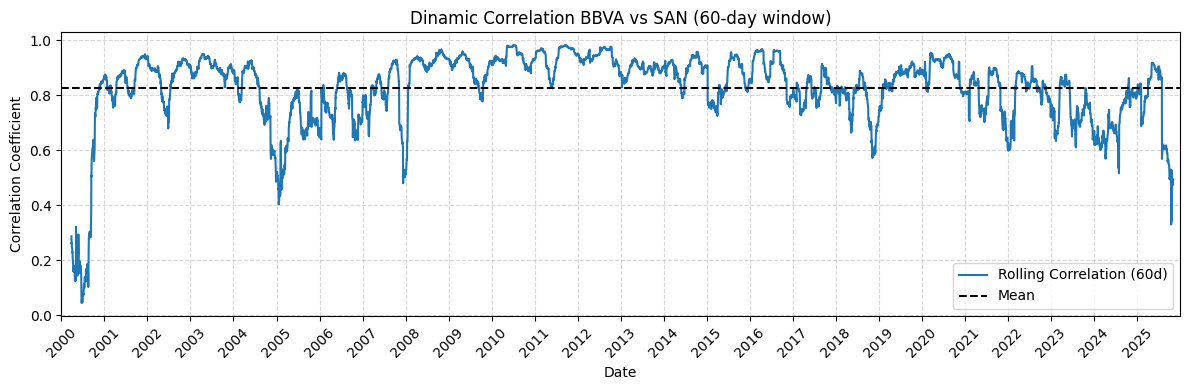

In [58]:
# orrelación móvil con ventana de 60 días (≈ 3 meses)
rolling_corr = bbva["ReturnPCT"].rolling(60).corr(san["ReturnPCT"])

plt.figure(figsize=(12, 4))
plt.plot(rolling_corr, label="Rolling Correlation (60d)")
plt.axhline(rolling_corr.mean(), color="black", ls="--", label="Mean")
plt.title("Dinamic Correlation BBVA vs SAN (60-day window)")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

years = pd.date_range(start="2000-01-01", end="2025-01-01", freq="YS")
plt.xticks(years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-12-31"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

| Etapa         | Correlación media aproximada      | Interpretación económica                                                                                                |
| ------------- | --------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **2000–2007** | Alta y estable (≈ 0.8–0.9)        | Periodo de expansión del crédito y crecimiento conjunto del sector bancario español.                                    |
| **2008–2009** | Descenso pronunciado (≈ 0.5)      | Colapso de la correlación durante la Gran Crisis Financiera; reacciones desiguales de los bancos ante el pánico global. |
| **2010–2019** | Elevada pero variable (≈ 0.7–0.9) | Etapa de crisis de deuda soberana, seguida de una recuperación gradual y posterior estabilidad impulsada por el BCE.    |
| **2020–2023** | Moderada (≈ 0.6–0.8)              | Impacto de la pandemia, disrupciones geopolíticas (COVID-19, guerra de Ucrania) y ajustes en los tipos de interés.      |
| **2024–2025** | De alta a media (≈ 0.9 → 0.4)     | Divergencias recientes en la evolución bursátil; entornos macro y estrategias corporativas diferenciadas.               |